In [1]:
import argparse
import os
import numpy as np
import math
import sys
import torch
import torch.distributions as distributions
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torch.utils.data as Data
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
from scipy.io import savemat
import scipy.io as sio
import sys
import importlib
import datetime
import itertools
import pickle
import scipy
import matplotlib
import matplotlib.pyplot as plt
import random
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy.random import random
from scipy.linalg import sqrtm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV 

In [2]:
data_dir = "data/case30"
case_dir = os.path.join(data_dir)
number = 20000
train_index = 12000
valid_index = 16000
saveFile = "data/case30/FC_out/S1"

In [4]:
#input data
mat_input = os.path.join(case_dir, 'inputdata_sample.mat')
PQ_injection = np.transpose(scipy.io.loadmat(mat_input)['sampledata'])[0:number,:]
P_injection = PQ_injection.real
Q_injection = PQ_injection.imag
# print(Q_injection.shape)
pv = [1-1,2-1,13-1,22-1,23-1,27-1]
slack = 1-1
P_injection = np.delete(P_injection,slack,1)
Q_injection = np.delete(Q_injection,pv,1)
# print(Q_injection.shape)
PQ_injection = np.concatenate([P_injection, Q_injection], axis=1)      
#output data
mat_ang = os.path.join(case_dir, 'voltage_ang_reduced.mat')
mat_mag = os.path.join(case_dir, 'voltage_mag_reduced.mat')
voltage_ang = np.transpose(scipy.io.loadmat(mat_ang)['voltage_ang_reduced'])[0:number,:]
voltage_mag = np.transpose(scipy.io.loadmat(mat_mag)['voltage_mag_reduced'])[0:number,:]
voltage =  np.concatenate([voltage_ang,voltage_mag], axis=1) 
yTrain = torch.from_numpy(voltage[0:train_index,:])
xTrain = torch.from_numpy(PQ_injection[0:train_index,:])
yValid = torch.from_numpy(voltage[train_index:valid_index,:])
xValid = torch.from_numpy(PQ_injection[train_index:valid_index,:])
yTest = torch.from_numpy(voltage[valid_index:number,:])
xTest = torch.from_numpy(PQ_injection[valid_index:number,:])
dataset = torch.utils.data.TensorDataset(xTrain, yTrain)
print(xValid.shape)
print(xTrain.shape)
print(xTest.shape)

torch.Size([14000, 53])
torch.Size([2000, 53])
torch.Size([4000, 53])


In [5]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=400, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=32, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.00001, help="learning rate")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--labels_dim", type=int, default=53, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=53, help="size of each image dimension")
parser.add_argument("--hidden_dim", type=int, default=100, help="size of hidden_dim")
opt = parser.parse_args(args=[])
print(opt)

Namespace(batch_size=32, hidden_dim=100, img_size=53, labels_dim=53, lr=1e-05, n_cpu=8, n_epochs=400)


In [6]:
cuda = True if torch.cuda.is_available() else False
# Initialize generator and discriminator
time = []
loss_train = []  
loss_valid = [] 
batch_loss_train = [] 
avg_train_losses = []
class FC(nn.Module):
    def __init__(self):
        super(FC, self).__init__()

        def block(in_feat, out_feat):
            layers = [nn.Linear(in_feat, out_feat)]
            layers.append(nn.ReLU(inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.labels_dim, opt.hidden_dim),
            *block(opt.hidden_dim, opt.hidden_dim),
            #*block(opt.hidden_dim, opt.hidden_dim),
            nn.Linear(opt.hidden_dim, opt.img_size),
        )
    def forward(self, z):
        out = self.model(z)
        return out
# Initialize generator and discriminator
MLP = FC()
L2_loss = nn.MSELoss()
if cuda:
    MLP.cuda()
    L2_loss.cuda()
# Configure data loader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=opt.batch_size,
    shuffle=True,
)

# Optimizers
optimizer = torch.optim.Adam(MLP.parameters(), lr=opt.lr)
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [10]:
# ----------
#  Training
# ----------
batches_done = 0
for epoch in range(opt.n_epochs):

    for i, (xTrain, yTrain) in enumerate(dataloader):
            # -----------------
            #  Train Generator
            # -----------------
            # Start measuring time
            startTime = datetime.datetime.now()
            
            # Reset gradients
            optimizer.zero_grad()
            
            # Generate a batch of samples
            yHatTrain = MLP(xTrain.float())
            
            # Compute loss
            loss = L2_loss(yHatTrain,yTrain.float())
            
            # Compute gradients
            loss.backward()
            
            # Optimize
            optimizer.step()
            
            # Finish measuring time
            endTime = datetime.datetime.now()
            
            timeElapsed = abs(endTime - startTime).total_seconds()
            
            time.append(timeElapsed)
            
            batch_loss_train.append(loss.item())  
            print(
                "[Epoch %d/%d] [Batch %d/%d][G loss: %.8f]"
                % (epoch, opt.n_epochs, batches_done % len(dataloader), len(dataloader), loss.item()))
            #VALIDATION
            if (batches_done % (len(yValid)//opt.batch_size) == 0):

                with torch.no_grad(): 
                    yHatValid = MLP(xValid.float()) 
                    # Compute loss
                    lossValueValid = L2_loss(yHatValid, yValid)
                    loss_valid.append(lossValueValid.item())
                    
                if epoch >= 599:
                    if (epoch == 599):
                        bestScore = lossValueValid
                        torch.save(MLP.state_dict(), saveFile +'Best'+'.ckpt')
                        torch.save(optimizer.state_dict(), saveFile+'Optim'+'Best'+'.ckpt')
                    else:
                        thisValidScore = lossValueValid
                        if thisValidScore < bestScore:
                            bestScore = thisValidScore
                            torch.save(MLP.state_dict(), saveFile + 'Best'+'.ckpt')
                            torch.save(optimizer.state_dict(), saveFile+'Optim'+'Best'+'.ckpt') 
            batches_done += 1
    train_loss = np.average(batch_loss_train)
    avg_train_losses.append(train_loss)
    batch_loss_train = []

[Epoch 0/400] [Batch 0/63][G loss: 0.09463119]
[Epoch 0/400] [Batch 1/63][G loss: 0.09091955]
[Epoch 0/400] [Batch 2/63][G loss: 0.09438310]
[Epoch 0/400] [Batch 3/63][G loss: 0.09235551]
[Epoch 0/400] [Batch 4/63][G loss: 0.09370957]
[Epoch 0/400] [Batch 5/63][G loss: 0.09413884]
[Epoch 0/400] [Batch 6/63][G loss: 0.09480175]
[Epoch 0/400] [Batch 7/63][G loss: 0.09162755]
[Epoch 0/400] [Batch 8/63][G loss: 0.09004709]
[Epoch 0/400] [Batch 9/63][G loss: 0.09258413]
[Epoch 0/400] [Batch 10/63][G loss: 0.09208512]
[Epoch 0/400] [Batch 11/63][G loss: 0.08993930]
[Epoch 0/400] [Batch 12/63][G loss: 0.09106921]
[Epoch 0/400] [Batch 13/63][G loss: 0.09107219]
[Epoch 0/400] [Batch 14/63][G loss: 0.08947174]
[Epoch 0/400] [Batch 15/63][G loss: 0.08968648]
[Epoch 0/400] [Batch 16/63][G loss: 0.09004109]
[Epoch 0/400] [Batch 17/63][G loss: 0.09213080]
[Epoch 0/400] [Batch 18/63][G loss: 0.08984383]
[Epoch 0/400] [Batch 19/63][G loss: 0.08755630]
[Epoch 0/400] [Batch 20/63][G loss: 0.09089234]
[E

[Epoch 5/400] [Batch 12/63][G loss: 0.03863936]
[Epoch 5/400] [Batch 13/63][G loss: 0.03549360]
[Epoch 5/400] [Batch 14/63][G loss: 0.03747651]
[Epoch 5/400] [Batch 15/63][G loss: 0.03583548]
[Epoch 5/400] [Batch 16/63][G loss: 0.03733332]
[Epoch 5/400] [Batch 17/63][G loss: 0.03574836]
[Epoch 5/400] [Batch 18/63][G loss: 0.03682668]
[Epoch 5/400] [Batch 19/63][G loss: 0.03688836]
[Epoch 5/400] [Batch 20/63][G loss: 0.03476656]
[Epoch 5/400] [Batch 21/63][G loss: 0.03465074]
[Epoch 5/400] [Batch 22/63][G loss: 0.03464374]
[Epoch 5/400] [Batch 23/63][G loss: 0.03455183]
[Epoch 5/400] [Batch 24/63][G loss: 0.03521216]
[Epoch 5/400] [Batch 25/63][G loss: 0.03679039]
[Epoch 5/400] [Batch 26/63][G loss: 0.03622092]
[Epoch 5/400] [Batch 27/63][G loss: 0.03525424]
[Epoch 5/400] [Batch 28/63][G loss: 0.03524744]
[Epoch 5/400] [Batch 29/63][G loss: 0.03338228]
[Epoch 5/400] [Batch 30/63][G loss: 0.03500716]
[Epoch 5/400] [Batch 31/63][G loss: 0.03456375]
[Epoch 5/400] [Batch 32/63][G loss: 0.03

[Epoch 10/400] [Batch 25/63][G loss: 0.01299878]
[Epoch 10/400] [Batch 26/63][G loss: 0.01313657]
[Epoch 10/400] [Batch 27/63][G loss: 0.01303921]
[Epoch 10/400] [Batch 28/63][G loss: 0.01382991]
[Epoch 10/400] [Batch 29/63][G loss: 0.01429705]
[Epoch 10/400] [Batch 30/63][G loss: 0.01349493]
[Epoch 10/400] [Batch 31/63][G loss: 0.01280640]
[Epoch 10/400] [Batch 32/63][G loss: 0.01328345]
[Epoch 10/400] [Batch 33/63][G loss: 0.01401909]
[Epoch 10/400] [Batch 34/63][G loss: 0.01363770]
[Epoch 10/400] [Batch 35/63][G loss: 0.01283324]
[Epoch 10/400] [Batch 36/63][G loss: 0.01349533]
[Epoch 10/400] [Batch 37/63][G loss: 0.01325971]
[Epoch 10/400] [Batch 38/63][G loss: 0.01232453]
[Epoch 10/400] [Batch 39/63][G loss: 0.01392353]
[Epoch 10/400] [Batch 40/63][G loss: 0.01431772]
[Epoch 10/400] [Batch 41/63][G loss: 0.01259620]
[Epoch 10/400] [Batch 42/63][G loss: 0.01181246]
[Epoch 10/400] [Batch 43/63][G loss: 0.01251037]
[Epoch 10/400] [Batch 44/63][G loss: 0.01370247]
[Epoch 10/400] [Batc

[Epoch 13/400] [Batch 6/63][G loss: 0.00858685]
[Epoch 13/400] [Batch 7/63][G loss: 0.00849323]
[Epoch 13/400] [Batch 8/63][G loss: 0.00875511]
[Epoch 13/400] [Batch 9/63][G loss: 0.00919322]
[Epoch 13/400] [Batch 10/63][G loss: 0.00899345]
[Epoch 13/400] [Batch 11/63][G loss: 0.00790948]
[Epoch 13/400] [Batch 12/63][G loss: 0.00758681]
[Epoch 13/400] [Batch 13/63][G loss: 0.00906232]
[Epoch 13/400] [Batch 14/63][G loss: 0.00839468]
[Epoch 13/400] [Batch 15/63][G loss: 0.00844351]
[Epoch 13/400] [Batch 16/63][G loss: 0.00745332]
[Epoch 13/400] [Batch 17/63][G loss: 0.00855323]
[Epoch 13/400] [Batch 18/63][G loss: 0.00785616]
[Epoch 13/400] [Batch 19/63][G loss: 0.00865570]
[Epoch 13/400] [Batch 20/63][G loss: 0.00779222]
[Epoch 13/400] [Batch 21/63][G loss: 0.00775475]
[Epoch 13/400] [Batch 22/63][G loss: 0.00819168]
[Epoch 13/400] [Batch 23/63][G loss: 0.00875545]
[Epoch 13/400] [Batch 24/63][G loss: 0.00772070]
[Epoch 13/400] [Batch 25/63][G loss: 0.00791661]
[Epoch 13/400] [Batch 26

[Epoch 18/400] [Batch 19/63][G loss: 0.00421209]
[Epoch 18/400] [Batch 20/63][G loss: 0.00406972]
[Epoch 18/400] [Batch 21/63][G loss: 0.00418456]
[Epoch 18/400] [Batch 22/63][G loss: 0.00453803]
[Epoch 18/400] [Batch 23/63][G loss: 0.00384165]
[Epoch 18/400] [Batch 24/63][G loss: 0.00449502]
[Epoch 18/400] [Batch 25/63][G loss: 0.00450066]
[Epoch 18/400] [Batch 26/63][G loss: 0.00362388]
[Epoch 18/400] [Batch 27/63][G loss: 0.00497363]
[Epoch 18/400] [Batch 28/63][G loss: 0.00417817]
[Epoch 18/400] [Batch 29/63][G loss: 0.00417863]
[Epoch 18/400] [Batch 30/63][G loss: 0.00417715]
[Epoch 18/400] [Batch 31/63][G loss: 0.00420362]
[Epoch 18/400] [Batch 32/63][G loss: 0.00470972]
[Epoch 18/400] [Batch 33/63][G loss: 0.00418765]
[Epoch 18/400] [Batch 34/63][G loss: 0.00381665]
[Epoch 18/400] [Batch 35/63][G loss: 0.00439175]
[Epoch 18/400] [Batch 36/63][G loss: 0.00392089]
[Epoch 18/400] [Batch 37/63][G loss: 0.00363622]
[Epoch 18/400] [Batch 38/63][G loss: 0.00404105]
[Epoch 18/400] [Batc

KeyboardInterrupt: 

In [9]:
print(sum(time)/opt.n_epochs)

0.0033677250000000037


In [168]:
torch.save(time, saveFile + 'Time')
torch.save(MLP.state_dict(), saveFile + 'Last'+'.ckpt')
torch.save(optimizer.state_dict(), saveFile+'Optim'+'Last'+'.ckpt') 
np.save(saveFile+'Train',avg_train_losses)
np.save(saveFile+'Valid',loss_valid)

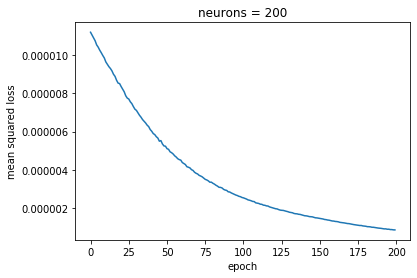

In [20]:
plt.plot(avg_train_losses[200:800])
plt.ylabel('mean squared loss')
plt.xlabel('epoch')
plt.title('neurons = 200')
plt.show()

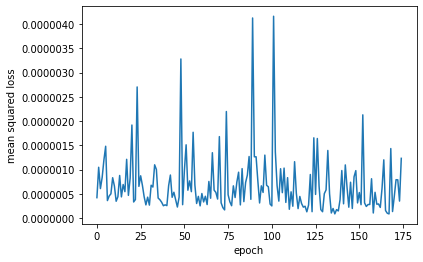

In [15]:
plt.plot(loss_valid[300:1000:4])
plt.ylabel('mean squared loss')
plt.xlabel('epoch')
plt.show()

In [21]:
MLP.eval()
yHatTest = MLP(xTest.float())
rmse_test = np.mean((yHatTest.detach().numpy()-yTest.detach().numpy())**2)
print(rmse_test)
rmse_test1 = np.sqrt(np.mean((yHatTest.detach().numpy()-yTest.detach().numpy())**2,0))
print(rmse_test1)
print(np.mean(rmse_test1[0:29]))
print(np.mean(rmse_test1[29:53]))

9.175846156055282e-07
[0.00045288 0.00058008 0.00061395 0.00070776 0.00083425 0.00099034
 0.00075247 0.00064424 0.00071743 0.00119712 0.001079   0.0008477
 0.00078114 0.00091715 0.00089158 0.00082842 0.00080249 0.00094211
 0.00096228 0.00104545 0.00070503 0.00068181 0.00084928 0.00072435
 0.00101259 0.00087538 0.00087514 0.00104108 0.00096966 0.00062607
 0.00052083 0.00072558 0.00061842 0.00102386 0.00075147 0.00079042
 0.00051499 0.00095399 0.0009614  0.00137384 0.00090115 0.00099179
 0.0008749  0.00118993 0.00127709 0.00142136 0.00058354 0.00112211
 0.00074207 0.00279011 0.00069038 0.000779   0.00100381]
0.0008386954185389345
0.0009678372016926525


In [173]:
np.save(saveFile+'rmse_test_last',rmse_test1)
np.save(saveFile+'yHatTest_last',yHatTest.detach().numpy())

In [11]:
model = FC()
model.load_state_dict(torch.load(saveFile + 'Best'+'.ckpt'))
optimizer.load_state_dict(torch.load(saveFile+'Optim'+'Best'+'.ckpt'))
model.eval()
yHatTest = model(xTest.float())
rmse_test2 = np.mean((yHatTest.detach().numpy()-yTest.detach().numpy())**2)
print(rmse_test2)
rmse_test3 = np.sqrt(np.mean((yHatTest.detach().numpy()-yTest.detach().numpy())**2,0))
print(rmse_test3)
print(np.mean(rmse_test3[0:29]))
print(np.mean(rmse_test3[29:53]))

4.712719003545878e-08
[1.84152989e-04 1.23225731e-04 2.22994648e-04 1.29892756e-04
 1.51690021e-04 1.99383160e-04 1.56316603e-04 1.94782117e-04
 2.18508642e-04 2.12015556e-04 2.16107593e-04 2.68681129e-04
 2.32020357e-04 2.27120919e-04 2.14841316e-04 2.32141222e-04
 2.14871557e-04 2.19791250e-04 2.16045669e-04 2.39793253e-04
 2.42832902e-04 2.97689143e-04 2.73570821e-04 3.07780605e-04
 3.11403848e-04 3.62099788e-04 1.64097296e-04 4.39910905e-04
 4.55703134e-04 1.66565472e-04 1.83299850e-04 1.43887427e-04
 1.41764203e-04 1.41500938e-04 1.56696377e-04 1.34364812e-04
 1.36359453e-04 1.38999371e-04 1.75434643e-04 1.69762131e-04
 1.37100751e-04 1.50400722e-04 1.22783743e-04 1.41165908e-04
 1.21447461e-04 1.23194564e-04 6.58165215e-05 1.52249459e-04
 1.07625287e-04 1.76149535e-04 1.62332954e-04 3.16324103e-04
 3.20424033e-04]
0.00023894706657246164
0.00015773540492221243


In [175]:
np.save(saveFile+'rmse_test_best',rmse_test3)
np.save(saveFile+'yHatTest_best',yHatTest.detach().numpy())